# Dublin Bikes time series cluster analysis + map plotting

In [71]:
import pandas as pd
import os
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')

df = pd.DataFrame()

# Read in the bikes data
data_path = './s3_data/'
for f in os.listdir(data_path)[:]:
    if 'bikes' in f and f.split(".")[-1] == 'csv':
        try:
            tmp = pd.read_csv(data_path + f,index_col=0)
            date = f.split("_")[1].split(".")[0]
            tmp.index = (pd.to_datetime(pd.Series(tmp.index).apply(lambda x: " ".join([date,x])),
                                 yearfirst=True))
            df = pd.concat([df,tmp],axis=0)
        except:
            print("Error in file {}".format(f))

Error in file bikes_300715_to_070815.csv


In [134]:
## Let's build up a timeseries of each station averaged over just days of the week

# Step 1 - get data for weekdays only
import datetime as dt
weekday_avg = df.copy()
weekday_avg['weekday'] = weekday_avg.index.weekday
weekday_avg = weekday_avg.loc[weekday_avg['weekday'] < 5]
del weekday_avg['weekday']

# resample by one minute and backfill nans
weekday_avg = weekday_avg.resample('5T').mean().bfill() 
# Groupby minute of day and take average for each station
weekday_avg['time'] = weekday_avg.index.to_series().apply(lambda x: dt.datetime.strftime(x, '%H:%M'))
weekday_avg = weekday_avg.groupby('time').agg('mean')
weekday_avg = weekday_avg.astype(int)

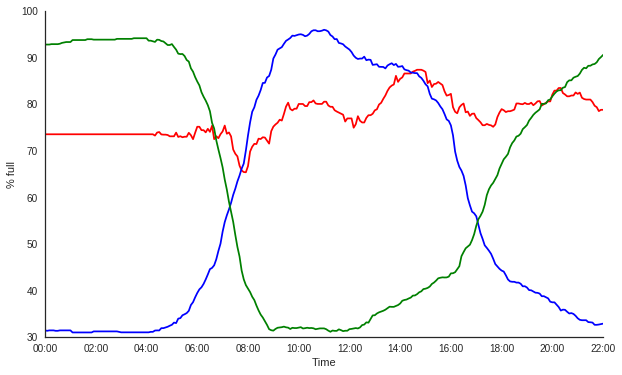

In [353]:
# Now we'll do the kmeans clustering
from sklearn.cluster import KMeans

n_clusters = 3

fig, ax = plt.subplots(figsize=(10,6))
colours = ['red','blue','green']

# Normalise each station to between 0 and 1 as each station has different capacity
df_norm = weekday_avg/weekday_avg.max()

# Fit kmeans model and plot the centroids
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df_norm.T)
for k, colour in zip(kmeans.cluster_centers_, colours):
    plt.plot(100*k,color=colour,label=colour)
    
ax.set_xlim([0,250])
ax.set_ylim([30,100])
xticks = ax.get_xticks()
xticks=range(0,288,24)
new_ticks = [times[i] for i in [int(_) for _ in xticks]]
plt.xticks(xticks, new_ticks, rotation='horizontal')
plt.xlabel('Time')
plt.ylabel("% full")
sns.despine()
plt.show()

clusters = kmeans.predict(df_norm.T)

# Mapping station clusters with folium

In [288]:
# Get station location data - saved in external file
locations = pd.read_csv('/home/james/Documents/dublinbikes/station_locations.csv')
locations['Name'] = locations['Name'].apply(lambda x : "_".join(x.split()))
locations = locations[['Name','Latitude','Longitude']]
locations = locations.set_index('Name')
# assign clusters found in kmeans model
locations['Cluster'] = pd.Series(index=df_norm.T.index.values,data=clusters)

In [347]:
import folium
mp = folium.Map(location=[53.34, -6.2603], zoom_start=14,tiles='cartodbpositron')
for c , colour in zip(range(n_clusters),colours):
    tmp = locations[locations['Cluster'] == c]
#     for 
    for location in tmp.iterrows():
            folium.CircleMarker(
                location=[location[1]['Latitude'],location[1]['Longitude']],
                radius=7,
                popup=location[0],
                color=colour,
                fill_color=colour
            ).add_to(mp)

mp.save('map.html')
mp